%%latex
\tableofcontents

# Introduction

Understanding the distribution of variants across population groups, and within population groups is needed to better understand population structure and any forces that may be shaping that structure. This notebook will describe patterns in variant frequency distribution across population groups. Statistical methods will be used to examine differences in frequency distribution between multiple subsets of mutations found, to identify variants of note.

The data used in this notebook  is a valuable tool to identify patterns that are associated with biological function. Using these types of annotations, we describe clinically relevant variants and investigate their impact in greater detail.


> This notebook will import and make use of data that has already been filtered to identify variants of clinical interest. The criteria used are described in the first notebook of this series, which also describes the code used to perform the data.

## Objectives

This notebook will focus on the following objectives:

- To verify the distribution models that apply to the observed variant frequencies
- To identify significant differences of variant frequency grouped by consequence type:
    - between populations
    - within populations
- To identify significant differences of variant frequency grouped by exon:
    - between populations
    - within populations

## Notebook Configuration

### Dependencies

This notebook will make use of the following python packages to perform the described analysis:

In [21]:
from pandas import read_csv, melt, to_numeric
from os.path import join
from statannotations.Annotator import Annotator
from itertools import combinations
from matplotlib.pyplot import (
    xlim,
    figure,
    subplots,
    subplots_adjust,
)
from seaborn import boxplot, move_legend, color_palette, set_theme, histplot
from scipy.stats import norm, normaltest
from statsmodels.graphics.gofplots import qqplot
from os.path import join
from pathlib import Path
from json import load

from typing import Dict
from matplotlib.figure import Figure
from matplotlib.gridspec import GridSpec
from matplotlib.figure import SubFigure
from seaborn import lineplot

In [12]:
with open(join("config", "manifest.json"), 'r') as config:
    config = load(config)

path = join(*config["output"])

### Data Imports

Before we start graphing, lets first set up some standard information that will be needed:

In [13]:
# [ASSIGN] the sample metadata used to conduct the analysis to a reference variable
SAMPLES = read_csv(join("input", "samples.csv"))

# [ASSIGN] the genomic location metadata used to conduct the analysis to a reference variable
LOCATIONS = read_csv(join("input", "locations.csv"))

# [ASSIGN] the dataset metadata used to conduct the analysis to a reference variable
DATASETS = read_csv(join("input", "datasets.csv"))

# [ASSIGN] a sorted list of all the unique population codes found in the annotations used in this analysis.
POPULATIONS_TO_COMPARE = sorted(SAMPLES["super-population"].unique().tolist())

# [ASSIGN] a sorted list of the genomic regions analyzed
GENES_TO_ANALYSE = sorted(LOCATIONS["location_name"].unique().tolist())

Next, lets import the results, which are stored in the form of CSV files grouped by cluster annotations provided during the analysis. This notebook will focus on the analysis of the clusters annotated in the super-population group.

In [14]:
# [SET] a dictionary to be used to house our data, indexed by gene
DATA = dict()

# [FOR] each gene in our list of gene regions included in this analysis...
for gene in GENES_TO_ANALYSE:
    # [ASSIGN] a DataFrame containing our imported gene-specific datasets to our DATA object
    DATA[gene] = read_csv(
        join(
            path,
            "consolidated_reports",
            f"super-population_{gene}.csv",
        ), sep="\t"
    )
    

In [15]:
# [FOR] each gene in our list of gene regions analyzed
for gene in GENES_TO_ANALYSE:
    
    DATA[gene].rename(columns={
        "Consequence_type": "Consequence"
    }, inplace=True)
    
    # [ASSIGN] the replaced column of data
    DATA[gene]["Consequence"] = DATA[gene]["Consequence"].replace({
    "regulatory_region_variant": "Regulatory Region",
    "upstream_gene_variant": "Upstream",
    "splice_polypyrimidine_tract_variant": "Splice Polypyrimidine Tract",
    "synonymous_variant": "Synonymous",
    "3_prime_UTR_variant": "3' UTR",
    "5_prime_UTR_variant": "5' UTR",
    "intergenic_variant": "Intergenic",
    "splice_region_variant": "Splice Region",
    "intron_variant": "Intron",
    "stop_gained": "Stop-Gain",
    "splice_donor_region_variant": "Splice Doner Region",
    "missense_variant": "Missense",
    "splice_acceptor_variant": "Splice Acceptor",
    "non_coding_transcript_exon_variant": "Non-Coding Transcript Exon",
    "downstream_gene_variant": "Downstream Gene",
    "TF_binding_site_variant": "TF Binding Site",
})

### Plot storage and configuration

To store our generated plots, we can use a python dictionary to store these in a hierarchical index, using the name of each gene region to order collections of related plots together. We can also make use of nested dictionaries to store multiple plot types for each gene.

In [16]:
# [STORE] of all plots we will be making. This figure is the canvas upon which all of the plotted data will be rendered onto.
FIGURE: Dict[str, Figure] = dict()

# [STORE] all Grid specifications for each plot. These define the individual plots sub-figures and axes.
GRIDSPEC: Dict[str, GridSpec] = dict()

# [STORE] all SubFigures in the figure layout.
SUBFIGURE: Dict[str, Dict[str, Dict[str, SubFigure]]] = dict()

# [STORE] all axes-level plots for each gene
QQ: Dict[str, SubFigure] = dict()
HIST = dict()
VIOLIN = dict()
HEATMAP = dict()

# [STORE] all axes which contain individual plots
AX = dict()

# [FOR] each gene, create a storage space for any plots generated (This should use a hierarchical storage structure of PLOT[gene][graph])
for gene in GENES_TO_ANALYSE:
    # [STORE] all plots for this gene
    AX[gene] = dict()
    SUBFIGURE[gene] = dict()

    # [ASSIGN] an empty dictionary to store all plots made for this gene
    FIGURE[gene] = figure(layout="constrained")

    FIGURE[gene].suptitle(f"Allele Frequency | {gene}")

    # [SET] the spacing/padding around plots in a figure or sub-figure.
    # FIGURE[gene].subplots_adjust(left=0.125, top=0.9, right=0.1, bottom=0.9, wspace=0.1, hspace=0.1)

    # # [SET] the layout engine to be used:
    # FIGURE[gene].set_layout_engine("tight")

    # [ASSIGN] a grid specification to the figure for use when placing sub-plots
    GRIDSPEC[gene] = FIGURE[gene].add_gridspec(nrows=4, ncols=1)

    for graph_type in ["QQ", "HIST", "VIOLIN", "HEATMAP"]:
        SUBFIGURE[gene][graph_type] = dict()


# [ASSIGN] a generic record to house plots that apply across genes
# FIGURE[None] = dict()

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

<Figure size 1000x1400 with 0 Axes>

Lets also set a few theme options that will apply to all of our plots:

In [17]:
# [CREDIT] for ratio sizes goes to a Bio-render article I found which talks about plot sizes
# https://www.biorender.com/blog/why-layout-and-scale-matters-for-graphs
set_theme(rc={"figure.figsize": (10, 14)}, style="ticks", palette="hls")

# Allele Frequency Distribution

First, lets look at the distribution of observed allele frequencies. This can be done using the Seaborn plot, [`boxplot`](https://seaborn.pydata.org/generated/seaborn.boxplot.html). By investigating these distribution observed, we can identify statistically significant differences within and between our population groups. We can use the [statannotations](https://pypi.org/project/statannotations/) package to run and apply statistical annotations to our boxplots.

## Q-Q plot with test for normality

In order to better understand the patterns in our data, lets start by visualizing the distribution of variant frequency across different grouping types. By visualizing our data in sets or groups, we can use statistics such as or derived from the Chi-Squared statistic to identify sets with significantly different distributions.

For this task, we can use the python [`statannotations`](https://pypi.org/project/statannotations/) package which provides an interface to access statistical functions offered by the wll-known [`scipy`](https://scipy.org/) statistical package, and apply these to plots generated using [`seaborn`](https://seaborn.pydata.org/), another well-known python graphing library. This facility offers the use of the following scipy statistical functions:

- [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu) | Mann-Whitney test
- [`ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#ttest-ind) & [`ttest_rel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#ttest-rel) | t-test (independent and paired)
- [`ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#ttest-ind) | Welch's t-test
- [`levene`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#levene) | Levene test
- [`wilcoxon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#wilcoxon) | Wilcoxon test
- [`kruskal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal) | Kruskal-Wallis test
- [`brunnermunzel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.brunnermunzel.html#scipy.stats.brunnermunzel) | Brunner-Munzel test

The [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu) method is ideal for our purposes since it is designed for unrelated samples. `Scipy.stats` does however note that in situations where the data being analyzed follows a normal-distribution, that a T-test would be more appropriate. Given this, we will first have to perform a test of distribution to determine if our data follows a normal distribution. For this, we can make use of the [`qqplot`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html) function from [`statsmodels`](https://www.statsmodels.org/stable/index.html).

A Q-Q Plot is used to understand how well our data fits to known models of distribution, such as the famous normal distribution. This is done by plotting the theoretical quartiles on the x-axis and our observed quartiles on the y-axis. In this case, we will generate a regression-line to indicate the goodness-of-fit visually.

In [ ]:
# [FOR] each gene in our list of genes
for geneIndex, gene in enumerate(GENES_TO_ANALYSE):

    # [ASSIGN] a new sub-figure for the Q-Q plot
    QQ[gene] = FIGURE[gene].add_subfigure(GRIDSPEC[gene][0,:], figsize=(10,14))

    # QQ[gene].subplots_adjust(left=0.1, right=0.9, top=0.88, bottom=0.02, wspace=0.125, hspace=0.5)

    # [ASSIGN] a new plot title
    QQ[gene].suptitle("Q-Q Distribution Test | Normal Distribution", size="medium")

    # [ASSIGN] a new plot x-label
    QQ[gene].supxlabel("Theoretical Quantiles", size="small")

    # [ASSIGN] a new plot y-label
    QQ[gene].supylabel("Sample Quantiles", size="small")
    
    AX[gene]["QQ"] = dict()
    
    # [ASSIGN] the number of columns to be made in this subplot
    quotient, remainder = divmod(len(POPULATIONS_TO_COMPARE), 4)

    if remainder != 0:
        _nrows = quotient + 1
    else:
        _nrows = quotient

    QQ_GRIDSPEC: GridSpec = QQ[gene].add_gridspec(nrows=_nrows, ncols=4)

    # [FOR] each population in our list of population groups
    for populationIndex, population in enumerate(POPULATIONS_TO_COMPARE):

        _row, _col = divmod(populationIndex, 4)

        
        # [ASSIGN] the results of the test for normality for later use
        isNormal = normaltest(DATA[gene][population])


        SUBFIGURE[gene]["QQ"][population] = QQ[gene].add_subfigure(QQ_GRIDSPEC[_row, _col])
        SUBFIGURE[gene]["QQ"][population].suptitle(population, size="x-small")
        # SUBFIGURE[gene]["QQ"][population].subplots_adjust(left=0.125, right=0.8, top=0.88, bottom=0.02, wspace=0.125, hspace=0.5)


        AX[gene]["QQ"][population] = SUBFIGURE[gene]["QQ"][population].add_subplot()
        AX[gene]["QQ"][population].tick_params(axis='y', rotation=48, labelsize='x-small')
        AX[gene]["QQ"][population].tick_params(axis='x', labelsize='x-small')


        
        # [PLOT] a Q-Q plot for a specific gene-population pair to the appropriate sub-plot axes
        qqplot(
            DATA[gene][population],
            dist=norm,
            fit=True,
            line="r",
            ax=AX[gene]["QQ"][population] 
        )

        AX[gene]["QQ"][population].set_ylabel(None)        
        AX[gene]["QQ"][population].set_xlabel(population, size="xx-small")
        
        # [IF] the p-value from our normality-test is less-than or equal to 0.05, we can safely reject the null hypothesis:
        if isNormal.pvalue <= 0.05:
            # [MUTATE] set the sub-plot background color to indicate significance
            AX[gene]["QQ"][population].set_facecolor("#ff000066")
        else:
            AX[gene]["QQ"][population].set_facecolor("lightgreen")


DivMod:  (2, 0)
DivMod:  (2, 0)
DivMod:  (2, 0)
DivMod:  (2, 0)
DivMod:  (2, 0)
DivMod:  (2, 0)
DivMod:  (2, 0)
DivMod:  (2, 0)


## Histogram of Frequency Distribution

In [ ]:
# [FOR] each gene in our list of genes
for geneIndex, gene in enumerate(GENES_TO_ANALYSE):

    # [ASSIGN] a new sub-figure for the Q-Q plot
    HIST[gene] = FIGURE[gene].add_subfigure(GRIDSPEC[gene][1,:])

    # QQ[gene].subplots_adjust(left=0.1, right=0.9, top=0.88, bottom=0.02, wspace=0.125, hspace=0.5)

    # [ASSIGN] a new plot title
    HIST[gene].suptitle("Allele Frequency Distribution", size="medium")
    _TMP = melt(DATA[gene], id_vars=["CHROM", "POS", "REF", "ALT"], value_vars=POPULATIONS_TO_COMPARE, value_name="Frequency", var_name="Super-Population")
    
    # [PLOT] a Q-Q plot for a specific gene-population pair to the appropriate sub-plot axes
    lineplot(_TMP, x="POS", y="Frequency", ax=AX[gene]["HIST"][population])
    
    


# Impact vs Allele Frequency


In [ ]:
from seaborn import violinplot


for geneIndex, gene in enumerate(GENES_TO_ANALYSE):
    VIOLIN[gene] = FIGURE[gene].add_subfigure(GRIDSPEC[gene][2,:])
    VIOLIN[gene].suptitle(f"Impact vs Freq | {gene}")

    # _TMP = melt(DATA[gene], id_vars=["CHROM", "POS", "REF", "ALT", "Impact"], value_vars=POPULATIONS_TO_COMPARE, value_name="Frequency", var_name="Super-Population")
    
    violinplot(DATA[gene], x="POS", y="", hue="Impact", ax=AX[gene]["VIOLIN"])

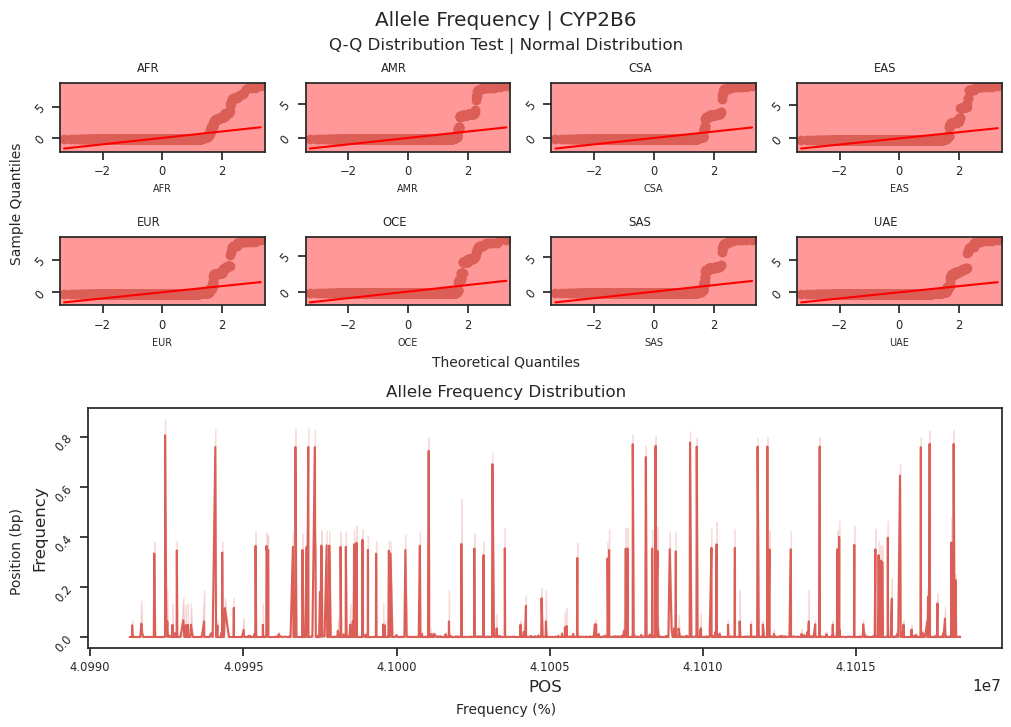

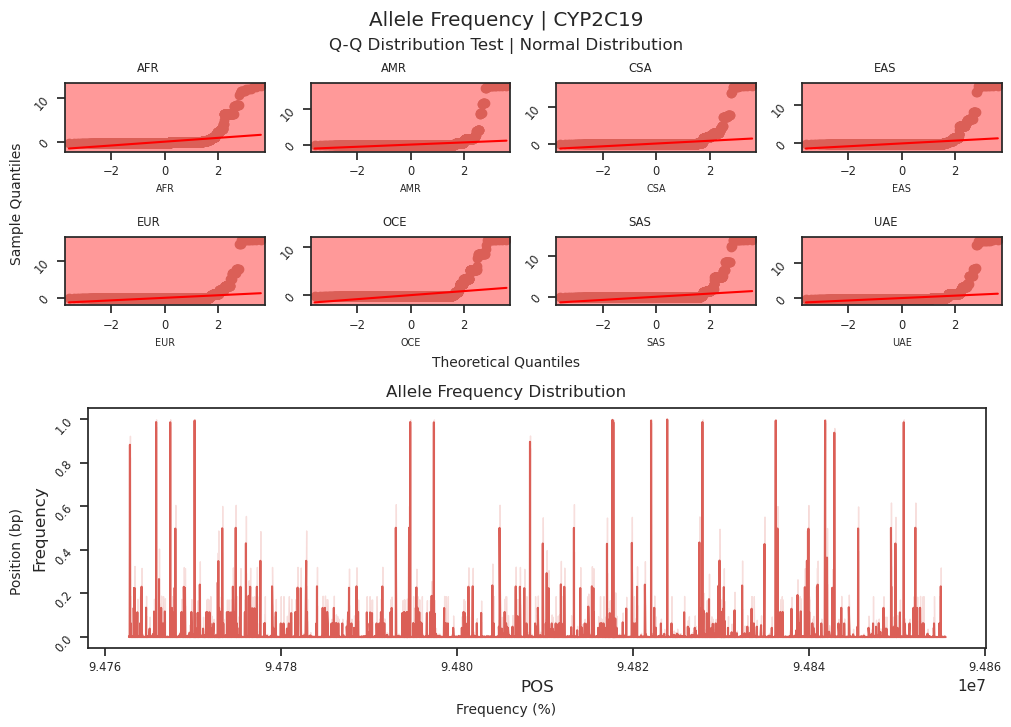

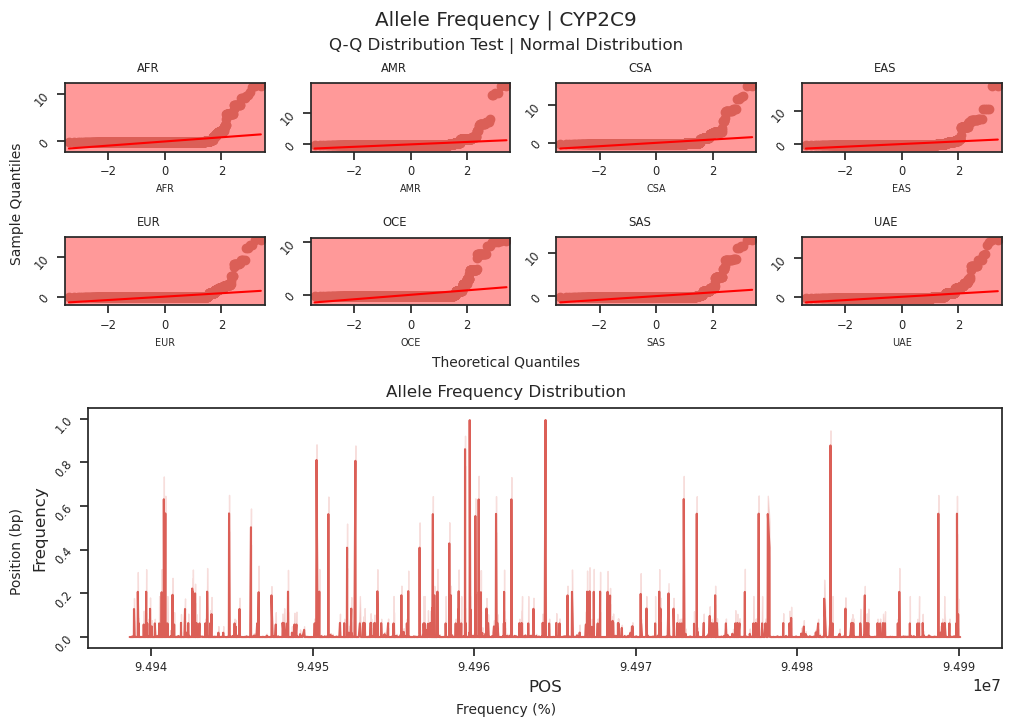

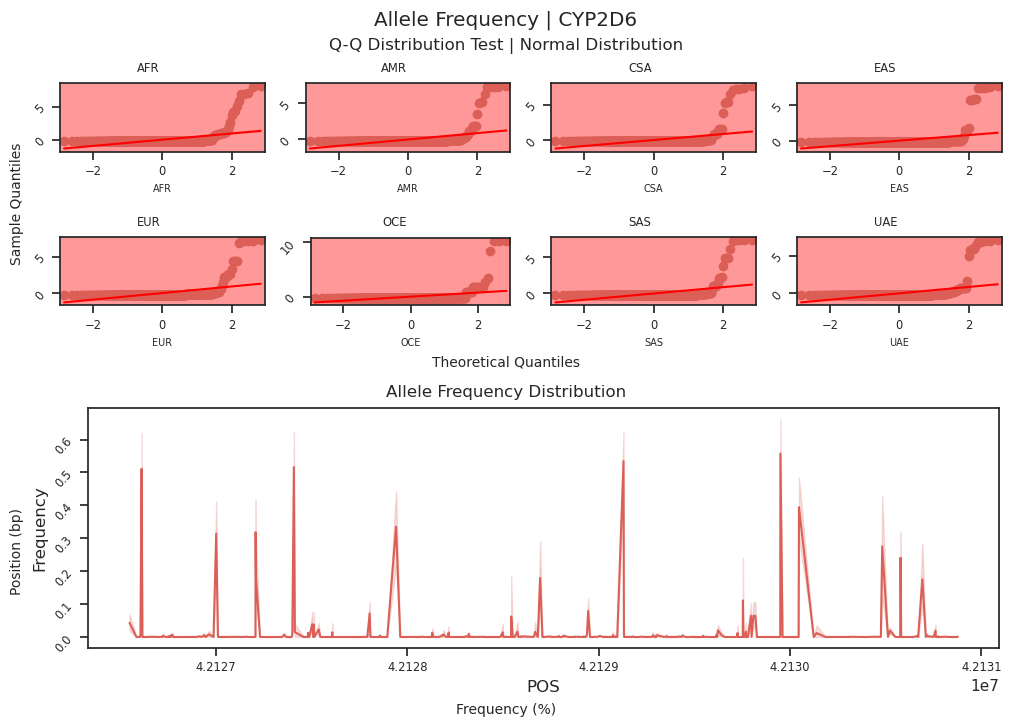

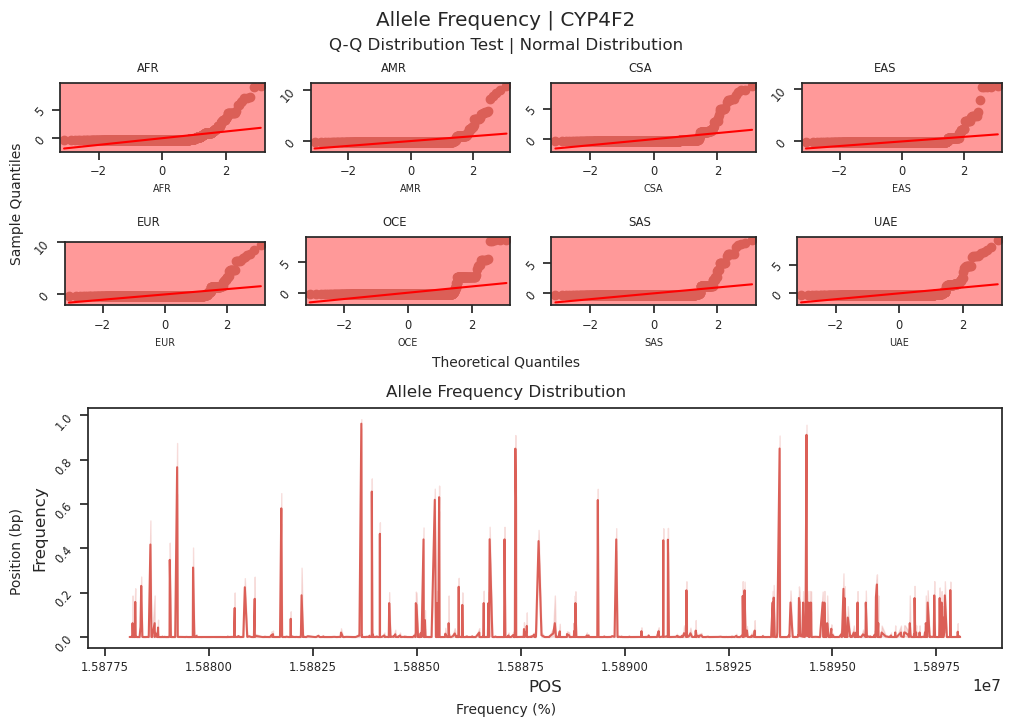

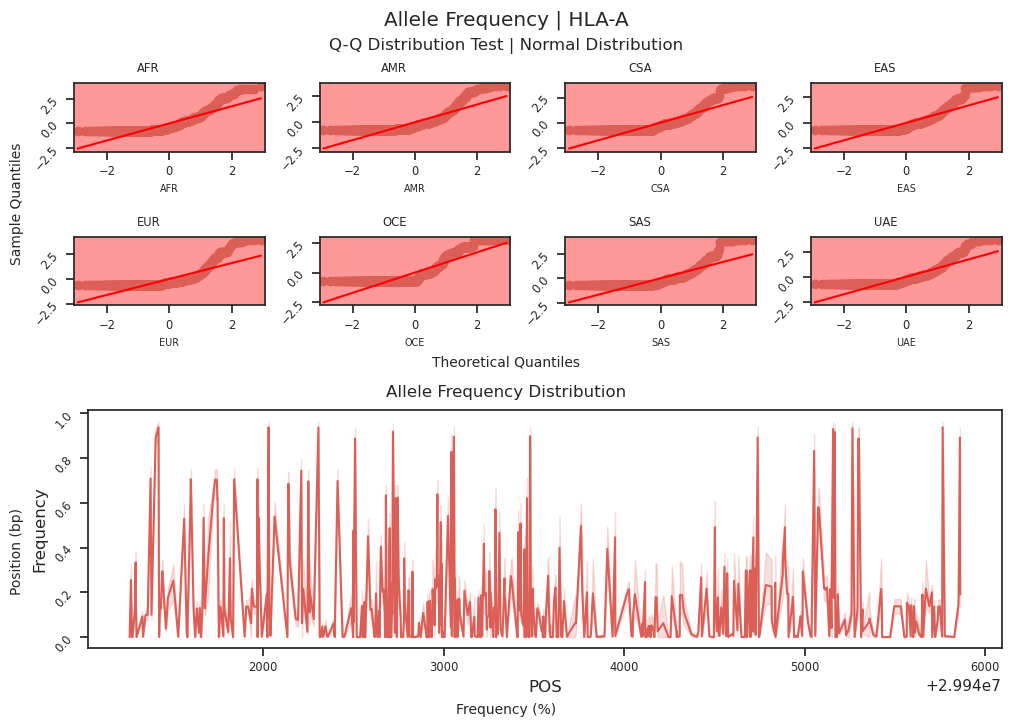

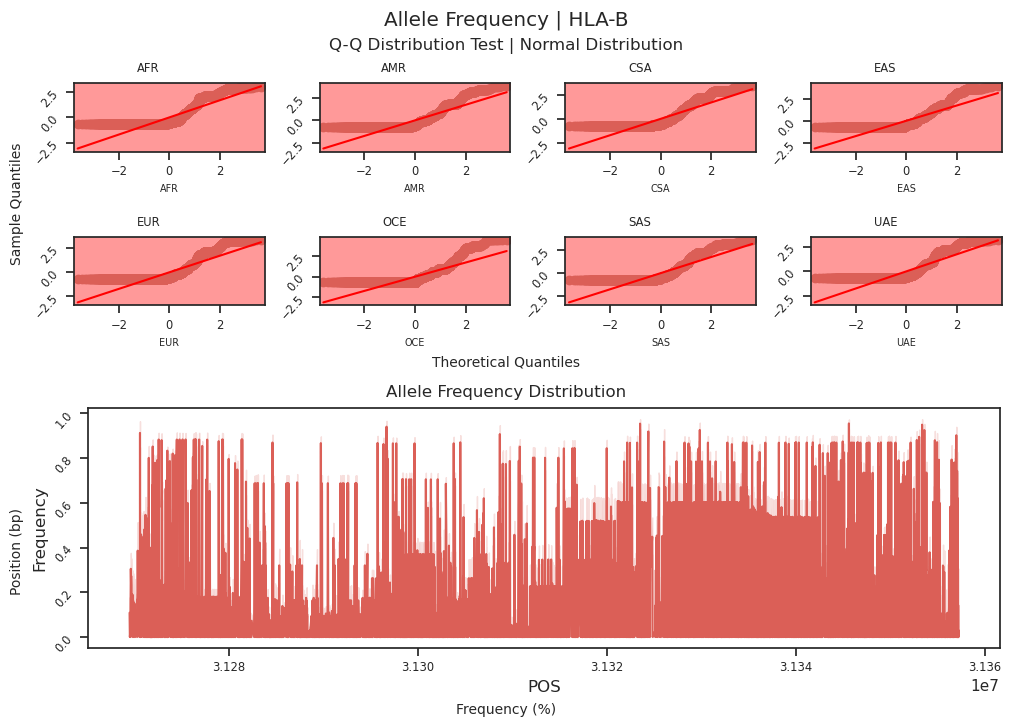

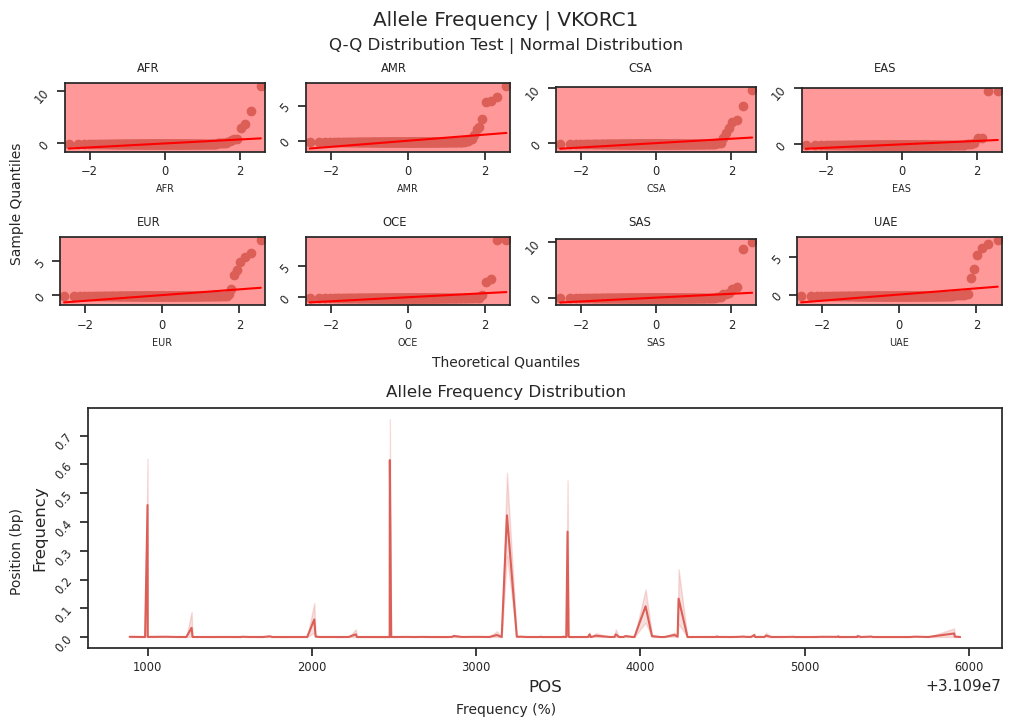

In [20]:
for gene in GENES_TO_ANALYSE:
    display(FIGURE[gene])

In [ ]:
# [ASSIGN] a new sub-figure for the Frequency Histogram


HEATMAP[gene] = FIGURE[gene].add_subfigure(GRIDSPEC[gene][3,:])
HEATMAP[gene].suptitle(f"VEP HeatMap | {gene}")

AX[gene]["HIST"] = HIST[gene].add_subplot()

AX[gene]["VIOLIN"] = VIOLIN[gene].add_subplot()

AX[gene]["HEATMAP"] = HEATMAP[gene].add_subplot()

As we can see from the above Q-Q plot, most of our gene-regions are noted with a significant p value. Although the data does show some degree of correlation, our normality test shows that there is a low probability of observing the frequencies found in the CYP2B6, CYP2C9, CYP2C19, CYP2D6, CYP4F2, HLA-A and HLA-B gene regions in a normally distributed dataset. Low-enough for us to confidently reject our null hypothesis that these frequency observations could have been sampled from a normally distributed population.

Based on the above findings, it will not be advisable to use a T-test, as this type of test relies on the assumption of normality. For this reason, we will opt for using the Mann-Whitney U-test, provided via the [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu) function.



## by consequence type

Now lets take a closer look at our frequency distribution from before, but this time, lets separate the data into groups by consequence type.

### within populations

In [ ]:
# [FOR] gene in genes to be analyzed
for gene in GENES_TO_ANALYSE:
    # [TRANSFORM] data columns from wide-format (col = variable) to long-format (col1=variable,col2=value)
    TMP = melt(
        DATA[gene],
        id_vars=["Consequence"],
        value_vars=POPULATIONS_TO_COMPARE,
        value_name="Frequency",
        var_name="Population",
    )

    # [PLOT] Init a new canvas, otherwise plots will be superimposed
    figure()

    # [ASSIGN] a sorted list of exons to be analyzed
    consequences_found = sorted(TMP["Consequence"].unique().tolist())
    
    # [PLOT] a box-plot describing frequencies, grouped by population and consequence type.
    FIGURE[gene]["consequence_within"] = boxplot(
        data=TMP,
        x="Population",
        y="Frequency",
        order=POPULATIONS_TO_COMPARE,
        hue="Consequence",
        hue_order=consequences_found,
        boxprops={'edgecolor': 'none'}
    )

    # [PLOT] x-axis dividers to help make identifying the small boxes with significance annotations easier
    for x_tick in FIGURE[gene]["consequence_within"].get_xticks():
        FIGURE[gene]["consequence_within"].axvline(x_tick+.5, linestyle="--", linewidth=0.5, color="lightgrey")


    # [PLOT] set limits on the y-axis
    FIGURE[gene]["consequence_within"].set(ylim=(0, 1))

    # [ASSIGN] a variable to house our tallied up filter expressions
    consequence_combinations_within_populations = list()

    # [FOR] each combination of any two consequence types possible...
    for consequence_1, consequence_2 in combinations(consequences_found, 2):
        # [ASSIGN] a temporary variable to house all combinations for the above-two consequences
        _tmp = list()

        # [FOR] each population in our list of populations to be compared
        for population in POPULATIONS_TO_COMPARE:
            # [ASSIGN] a set of comparison expressions to compare these two consequences within our populations
            _tmp.append(
                (( population, consequence_1), (population, consequence_2)),
            )
        # [ASSIGN] the filter expressions generated for the above consequence-comparison across all populations into our tally variable
        consequence_combinations_within_populations.extend(_tmp)

    # [STATS] Create our statistical testing interface and configure our data and plot to be used
    test_between_consequences = Annotator(
        FIGURE[gene]["consequence_within"],
        consequence_combinations_within_populations,
        data=TMP,
        x="Population",
        y="Frequency",
        order=POPULATIONS_TO_COMPARE,
        hue="Consequence",
        hue_order=consequences_found,
    )

    # [STATS] configure the statistical tests to be used, and the combinations to be tested
    test_between_consequences.configure(
        test="Mann-Whitney",
        text_format="star",
        loc="inside",
        comparisons_correction="bonferroni",
        hide_non_significant=True,
    )

    # [STATS] apply the statistics and annotate the results onto the plot
    test_between_consequences.apply_and_annotate()

    # [ASSIGN] the resultant x-axis limits to variables for downstream use
    _x_min, _x_max = xlim()

    # [PLOT] a horizontal line, indicating the natural limit on our graph
    FIGURE[gene]["consequence_within"].axhline(1.0, _x_min, _x_max, color="gray", linestyle="--")

    # [PLOT] a label for the aforementioned horizontal line
    FIGURE[gene]["consequence_within"].text(
        _x_min,
        1.01,
        c="gray",
        s="Max",
        verticalalignment="baseline",
        horizontalalignment="left",
    )

    # [PLOT] a title for our plot
    FIGURE[gene]["consequence_within"].figure.suptitle(
        f"Distribution of allele frequencies by consequence type (within populations) | {gene}"
    )

### between populations

In [ ]:
# [FOR] gene in list of genes covered in this analysis
for gene in GENES_TO_ANALYSE:

    # [TRANSFORM] data columns from wide-format (col = variable) to long-format (col1=variable,col2=value)
    TMP = melt(
        DATA[gene],
        id_vars=["Consequence"],
        value_vars=POPULATIONS_TO_COMPARE,
        value_name="Frequency",
        var_name="Population"
    )
     
    # [REPLACE] null values with "Non-Exon" for graphing purposes.
    TMP.fillna("Non-Exon", inplace=True)

    # [PLOT] Init a new canvas, otherwise plots will be superimposed
    figure()

    # [ASSIGN] a list of consequences to be analyzed
    consequences_found = sorted(TMP["Consequence"].unique().tolist())

    # [PLOT] a box-plot describing frequencies, grouped by population and consequence type.
    FIGURE[gene]["consequence_between"] = boxplot(
        data=TMP,
        x="Population",
        y="Frequency",
        order=POPULATIONS_TO_COMPARE,
        hue="Consequence",
        hue_order=consequences_found,
        boxprops={'edgecolor': 'none'}
    )

    # [PLOT] x-axis dividers to help make identifying the small boxes with significance annotations easier
    for x_tick in FIGURE[gene]["consequence_between"].get_xticks():
        FIGURE[gene]["consequence_between"].axvline(x_tick+.5, linestyle="--", linewidth=0.5, color="lightgrey")
        
    # [PLOT] set limits on the y-axis
    FIGURE[gene]["consequence_between"].set(ylim=(0, 1))

    # [ASSIGN] a variable to house our tallied up filter expressions
    consequence_combinations_between_populations = list()
    
    # [FOR] each consequence type found...
    for consequence in TMP["Consequence"].unique().tolist():
        _tmp = list()
        # [FOR] each combination of any two consequence types possible...
        for population in POPULATIONS_TO_COMPARE:
            if population != "AFR":
                # [ASSIGN] a set of comparison expressions to compare these two consequences between our populations
                _tmp.extend([(("AFR", consequence), (population, consequence))])
        
        # [ASSIGN] the filter expressions generated for the above consequence-comparison across all populations into our tally variable
        consequence_combinations_between_populations.extend(_tmp)

    # [SORT] these combinations and order them by exon, which will be our conditional-split/nested x-axis in this graph.
    print(consequence_combinations_between_populations)

    # [STATS] Create our statistical testing interface and configure our data and plot to be used
    test_between_consequences = Annotator(
        FIGURE[gene]["consequence_between"],
        consequence_combinations_between_populations,
        data=TMP,
        x="Population",
        y="Frequency",
        order=POPULATIONS_TO_COMPARE,
        hue="Consequence",
        hue_order=consequences_found,
        show_test_name=True
    )

    # [STATS] configure the statistical tests to be used, and the combinations to be tested
    test_between_consequences.configure(
        test="Mann-Whitney",
        text_format="star",
        loc="inside",
        comparisons_correction="bonferroni",
        hide_non_significant=True,
    )

    # [STATS] apply the statistics and annotate the results onto the plot
    test_between_consequences.apply_and_annotate()

    # [ASSIGN] the resultant x-axis limits to variables for downstream use
    _x_min, _x_max = xlim()

    # [PLOT] a horizontal line, indicating the natural limit on our graph
    FIGURE[gene]["consequence_between"].axhline(1, _x_min, _x_max, c="gray", ls=":")

    # [PLOT] a label for the aforementioned horizontal line
    FIGURE[gene]["consequence_between"].text(
        _x_min,
        1.01,
        c="gray",
        s="Max",
        verticalalignment="baseline",
        horizontalalignment="left",
    )

    # [PLOT] a title for our plot
    FIGURE[gene]["consequence_between"].figure.suptitle(
        f"Distribution of allele frequencies by consequence type (between populations) | {gene}"
    )

    # [PLOT] move the legend off of the graph
    move_legend(
        FIGURE[gene]["consequence_between"],
        "upper left",
        bbox_to_anchor=(1, 1),
    )

## by exon

Lets take a closer look at our frequency distribution like before> For this set, lets separate the data into groups by exon.

### within populations

In [ ]:
# [FOR] gene in list of genes covered in this analysis
for gene in GENES_TO_ANALYSE:

    # [TRANSFORM] data columns from wide-format (col = variable) to long-format (col1=variable,col2=value)
    TMP = melt(
        DATA[gene],
        id_vars=["Exon"],
        value_vars=POPULATIONS_TO_COMPARE,
        value_name="Frequency",
        var_name="Population",
    )

    # [ASSIGN] filler text for any variants which do not have an exon annotation
    TMP.fillna("Non-Exon", inplace=True)

    # [ASSIGN] a numeric sorting key, constructed using the numerator in the fraction-based exon labeling system
    TMP["Exon Sorting Key"] = TMP["Exon"].str.split("/", expand=True)[0]

    # [ASSIGN] the correct numerical sorting key for non-exon mutations which did not use the fraction-based exon labeling system
    TMP["Exon Sorting Key"].replace("Non-Exon", 0, inplace=True)

    # [ASSIGN] cast the column to a numeric type, to ensure no data-type confusion when plotting
    TMP["Exon Sorting Key"] = to_numeric(TMP["Exon Sorting Key"])

    # [SORT] the TMP DataFrame by the newly created sorting key
    TMP.sort_values(by="Exon Sorting Key", inplace=True)

    # [PLOT] Init a new canvas, otherwise plots will be superimposed
    figure()

    # [PLOT] a box-plot describing frequencies, grouped by population and consequence type.
    FIGURE[gene]["exon_within"] = boxplot(
        data=TMP,
        x="Population",
        y="Frequency",
        hue="Exon",
        hue_order=sorted(TMP["Exon"].unique().tolist()),
        boxprops={'edgecolor': 'none'}
    )

    # [PLOT] x-axis dividers to help make identifying the small boxes with significance annotations easier
    for x_tick in FIGURE[gene]["exon_within"].get_xticks():
        FIGURE[gene]["exon_within"].axvline(x_tick+.5, linestyle="--", linewidth=0.5, color="lightgrey")

    # [ASSIGN] a list of exons to be analysed
    exons_found = TMP["Exon"].unique().tolist()

    # [PLOT] set limits on the y-axis
    FIGURE[gene]["exon_within"].set(ylim=(0, 1))

    # [ASSIGN] a variable to house our tallied up filter expressions
    combinations_between_populations = list()

    # [FOR] each combination of any two consequence types possible...
    for exon_1, exon_2 in combinations(exons_found, 2):
        # [ASSIGN] a temporary variable to house all combinations for the above-two exons
        _tmp = list()

        # [FOR] each population in our list of populations to be compared
        for population in POPULATIONS_TO_COMPARE:
            # [ASSIGN] a set of comparison expressions to compare these two exons within our populations
            _tmp.extend([((population, exon_1), (population, exon_2))])

        # [ASSIGN] the filter expressions generated for the above exon-comparison across all populations into our tally variable
        combinations_between_populations.extend(_tmp)

    # [STATS] Create our statistical testing interface and configure our data and plot to be used
    test_between_consequences = Annotator(
        FIGURE[gene]["exon_within"],
        combinations_between_populations,
        data=TMP,
        x="Population",
        y="Frequency",
        hue="Exon",
        order=POPULATIONS_TO_COMPARE,
        hue_order=sorted(exons_found),
    )

    # [STATS] configure the statistical tests to be used, and the combinations to be tested
    test_between_consequences.configure(
        test="Mann-Whitney",
        text_format="star",
        loc="inside",
        comparisons_correction="bonferroni",
        hide_non_significant=True,
    )
    # [STATS] apply the statistics and annotate the results onto the plot
    test_between_consequences.apply_and_annotate()

    # [ASSIGN] the resultant x-axis limits to variables for downstream use
    _x_min, _x_max = xlim()

    # [PLOT] a horizontal line, indicating the natural limit on our graph
    FIGURE[gene]["exon_within"].axhline(1, _x_min, _x_max, c="gray", ls=":")

    # [PLOT] a label for the abovementioned horizontal line
    FIGURE[gene]["exon_within"].text(
        _x_min,
        1.01,
        c="gray",
        s="Max",
        verticalalignment="baseline",
        horizontalalignment="left",
    )

    # [PLOT] a title for our plot
    FIGURE[gene]["exon_within"].figure.suptitle(
        f"Distribution of allele frequencies by exon (within populations) | {gene}"
    )

    # [PLOT] move the legend off of the graph
    move_legend(
        FIGURE[gene]["exon_within"],
        "upper left",
        bbox_to_anchor=(1, 1),
    )

### between populations

In [ ]:
# [FOR] gene in list of genes covered in this analysis
for gene in GENES_TO_ANALYSE:

    # [TRANSFORM] data columns from wide-format (col = variable) to long-format (col1=variable,col2=value)
    TMP = melt(
        DATA[gene],
        id_vars=["Exon"],
        value_vars=POPULATIONS_TO_COMPARE,
        value_name="Frequency",
        var_name="Population",
    )

    # [ASSIGN] filler text for any variants which do not have an exon annotation
    TMP.fillna("Non-Exon", inplace=True)

    # [ASSIGN] a numeric sorting key, constructed using the numerator in the fraction-based exon labeling system
    TMP["Exon Sorting Key"] = TMP["Exon"].str.split("/", expand=True)[0]
    
    # [ASSIGN] the correct numerical sorting key for non-exon mutations which did not use the fraction-based exon labeling system
    TMP["Exon Sorting Key"].replace("Non-Exon", 0, inplace=True)

    # [ASSIGN] cast the column to a numeric type, to ensure no data-type confusion when plotting
    TMP["Exon Sorting Key"] = to_numeric(TMP["Exon Sorting Key"])

    # [SORT] the TMP DataFrame by the newly created sorting key
    TMP.sort_values(by="Exon Sorting Key", inplace=True)

    # [PLOT] Init a new canvas, otherwise plots will be superimposed
    figure()

    # [PLOT] a box-plot describing frequencies, grouped by population and consequence type.
    FIGURE[gene]["exon_between"] = boxplot(
        data=TMP,
        x="Population",
        y="Frequency",
        hue="Exon",
        hue_order=sorted(TMP["Exon"].unique().tolist()),
        boxprops={'edgecolor': 'none'},
        order=POPULATIONS_TO_COMPARE
    )

    # [PLOT] x-axis dividers to help make identifying the small boxes with significance annotations easier
    for x_tick in FIGURE[gene]["exon_between"].get_xticks():
        FIGURE[gene]["exon_between"].axvline(x_tick+.5, linestyle="--", linewidth=0.5, color="lightgrey")

    # [ASSIGN] a list of exons to be analyzed
    exons_found = TMP["Exon"].unique().tolist()

    # [PLOT] set limits on the y-axis
    FIGURE[gene]["exon_between"].set(ylim=(0, 1))
    
    # [ASSIGN] a variable to house our tallied up filter expressions
    combinations_between_populations = list()
    
    # [FOR] each exon found...
    for consequence in TMP["Exon"].unique().tolist():
        _tmp = list()
        for population in POPULATIONS_TO_COMPARE:
            if population != "AFR":
                _tmp.extend([(("AFR", consequence), ("AFR", consequence))])
        combinations_between_populations.extend(_tmp)
    
    # [STATS] order the combinations so that the annotations wont create visual noise
    combinations_between_populations.sort(key=lambda combination: combination[0])
    
    # [STATS] Create our statistical testing interface and configure our data and plot to be used
    test_between_consequences = Annotator(
        FIGURE[gene]["exon_between"],
        combinations_between_populations,
        data=TMP,
        x="Population",
        y="Frequency",
        hue="Exon",
        order=POPULATIONS_TO_COMPARE,
        hue_order=sorted(exons_found),
    )

    # [STATS] configure the statistical tests to be used, and the combinations to be tested
    test_between_consequences.configure(
        test="Mann-Whitney",
        text_format="star",
        loc="inside",
        comparisons_correction="bonferroni",
        hide_non_significant=True,
    )
    # [STATS] apply the statistics and annotate the results onto the plot
    test_between_consequences.apply_and_annotate()

    # [ASSIGN] the resultant x-axis limits to variables for downstream use
    _x_min, _x_max = xlim()
    
    # [PLOT] a horizontal line, indicating the natural limit on our graph
    FIGURE[gene]["exon_between"].axhline(1, _x_min, _x_max, c="gray", ls=":")
    
    # [PLOT] a label for the aforementioned horizontal line
    FIGURE[gene]["exon_between"].text(
        _x_min,
        1.01,
        c="gray",
        s="Max",
        verticalalignment="baseline",
        horizontalalignment="left",
    )
    
    # [PLOT] a title for our plot
    FIGURE[gene]["exon_between"].figure.suptitle(
        f"Distribution of allele frequencies by exon (between populations) | {gene}"
    )
    
    # [PLOT] move the legend off of the graph
    move_legend(
        FIGURE[gene]["exon_between"],
        "upper left",
        bbox_to_anchor=(1, 1),
    )

# Export

In [25]:
Path(join(path, "Graphs", "02")).mkdir(exist_ok=True, parents = True)

In [26]:
for gene in GENES_TO_ANALYSE:
    for graph in FIGURE[gene].keys(): 
        FIGURE[gene][graph].figure.savefig(join(path, "Graphs", "02", f"{gene}_{graph}.jpeg"))